In [1]:
import sys
import os
sys.path.append(os.path.abspath("../"))

In [2]:
from BEACH.lib import *

c = np.array([[0,2.5],[2,5+10]])

In [3]:
import pandas as pd
df = pd.DataFrame(c, columns=['j', 'coef'])
df.to_csv('coef_file.csv', index=False)

In [4]:
df = pd.read_csv('coef_file.csv')
df

,j,coef
0,0.0,2.5
1,2.0,15.0


In [5]:
len(c)

2

In [14]:
x,y = np.linspace(-50,50,100), np.linspace(-50,50,100)
Gen = GenBeam(1000,x,y,df['coef'].values)
z= Gen.basis_j((2,2))

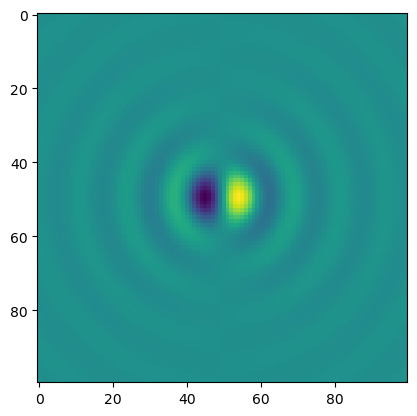

In [15]:
plt.imshow(z[1,:].reshape(100,100))

In [8]:
g = twoD_Gaussian(x,y,1,7,10,1,0,45,0)

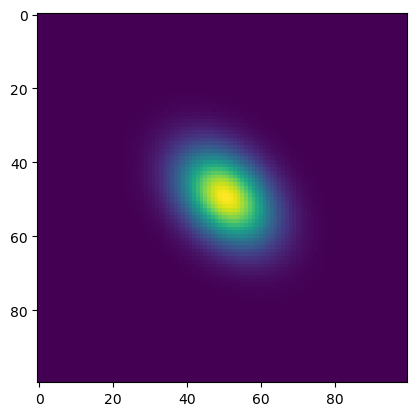

In [9]:
plt.imshow(g)

/var/folders/25/jcpftdwn4dz92_1tq7g2cdw40000gn/T/ipykernel_21891/177742212.py:22: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y.append(np.real(sph_harm(m, l, phi_grid, theta_grid)).flatten())
/var/folders/25/jcpftdwn4dz92_1tq7g2cdw40000gn/T/ipykernel_21891/177742212.py:23: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y.append(np.imag(sph_harm(m, l, phi_grid, theta_grid)).flatten())


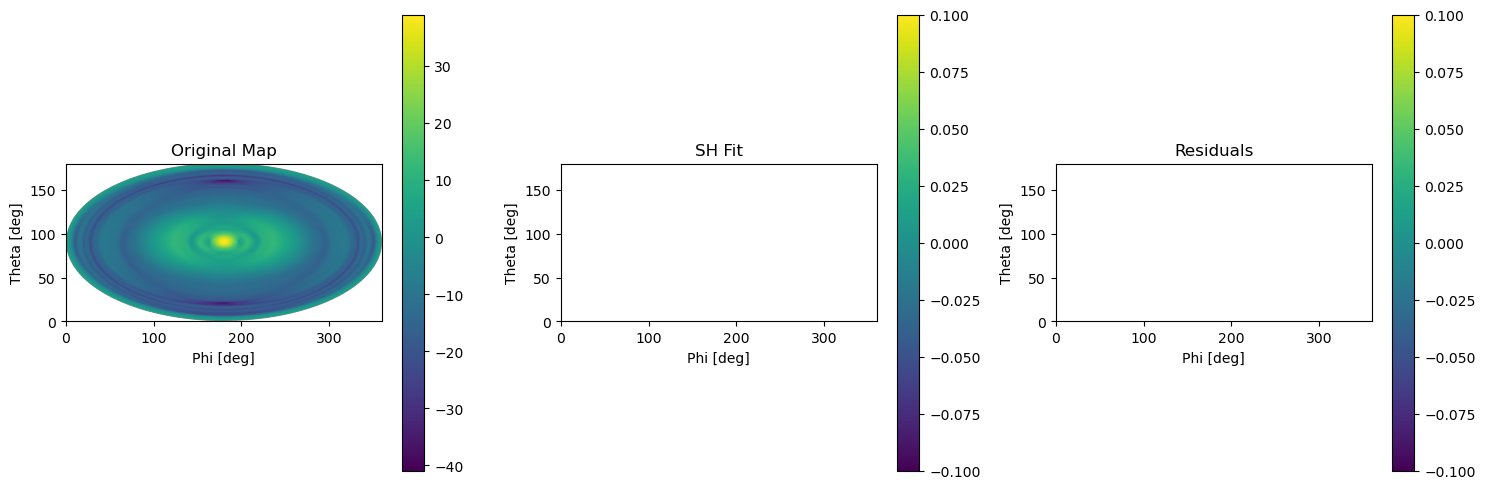

In [ ]:
plt.imshow(g-z[1,:].reshape(100,100))

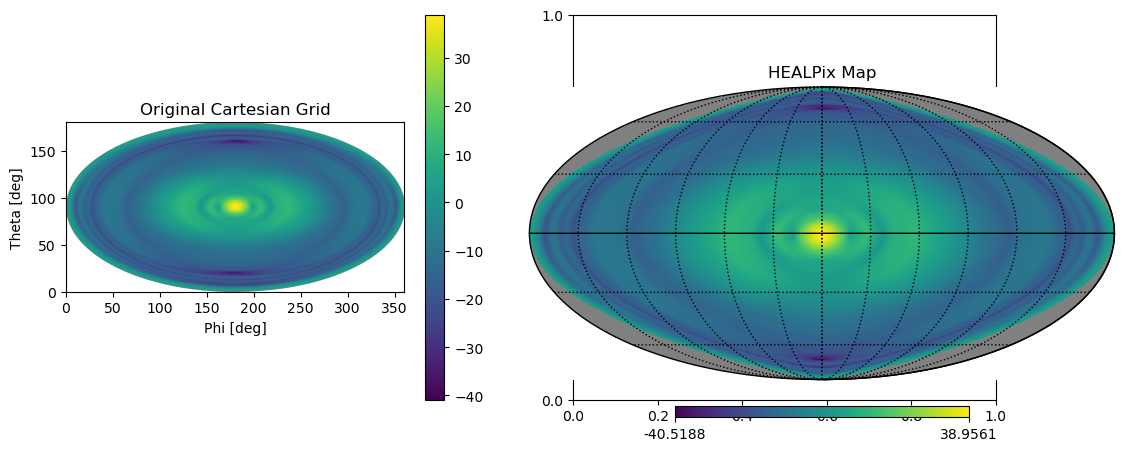

In [6]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
beam = np.load("../test_beam_2.1deg.npy")
# -----------------------
# 1. Create 2D Cartesian grid
# -----------------------
n_theta, n_phi = 1000, 1000
theta = np.linspace(0, np.pi, n_theta)       # colatitude
phi = np.linspace(0, 2*np.pi, n_phi)         # longitude
theta_grid, phi_grid = np.meshgrid(theta, phi, indexing='ij')

# Example map: function of theta and phi
map_2d = beam #np.sin(theta_grid) * np.cos(phi_grid)  # replace with your actual map

# -----------------------
# 2. Interpolate to HEALPix
# -----------------------
nside = 128
npix = hp.nside2npix(nside)

# HEALPix pixel angles
theta_pix, phi_pix = hp.pix2ang(nside, np.arange(npix))

# Interpolator
interp = RegularGridInterpolator(
    (theta, phi), map_2d, bounds_error=False, fill_value=0.0
)

# Interpolate Cartesian grid to HEALPix pixels
healpix_map = interp(np.stack([theta_pix, phi_pix], axis=-1))

# -----------------------
# 3. Plot comparison
# -----------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Original 2D grid
im0 = axs[0].imshow(map_2d, origin='lower', extent=[0, 360, 0, 180])
axs[0].set_title('Original Cartesian Grid')
axs[0].set_xlabel('Phi [deg]')
axs[0].set_ylabel('Theta [deg]')
plt.colorbar(im0, ax=axs[0])

# HEALPix map (Mollweide)
hp.mollview(healpix_map, title='HEALPix Map', sub=(1,2,2), rot=(180,0))
hp.graticule()

plt.show()


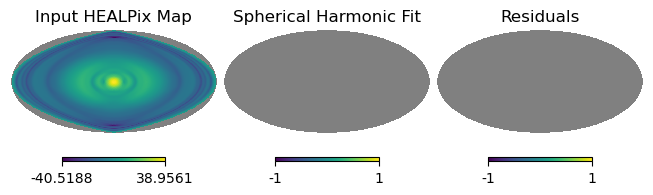

In [10]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

nside = 128
lmax_fit = 10   # choose maximum multipole for fit
alm = hp.map2alm(healpix_map, lmax=lmax_fit)    # spherical harmonic coefficients
fit_map = hp.alm2map(alm, nside, lmax=lmax_fit) # reconstructed map
residual_map = healpix_map - fit_map

# -----------------------
# 4. Plots
# -----------------------
hp.mollview(healpix_map, title="Input HEALPix Map", sub=(1,3,1), rot=(180,0))
hp.mollview(fit_map, title="Spherical Harmonic Fit", sub=(1,3,2), rot=(180,0))
hp.mollview(residual_map, title="Residuals", sub=(1,3,3), rot=(180,0))
#hp.graticule()

plt.show()


In [ ]:
#fitting test beam with Zernike polynomials

from BEACH.lib import *

x,y = np.linspace(-50,50,100), np.linspace(-50,50,100)


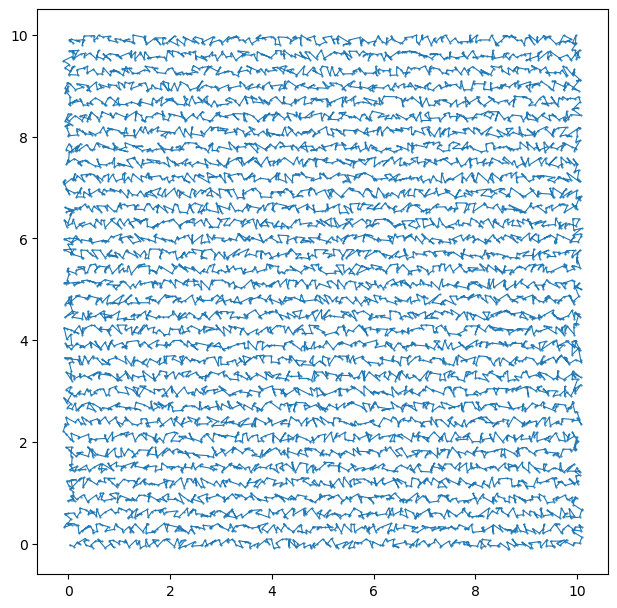

In [40]:
%matplotlib inline
import numpy as np
plt.clf()
def zigzag_uniform_area(width, height, dx=1.0, dy=1.0, ds=0.1, jitter=0.0):
    """
    Generate (x, y) coordinates for a continuous zigzag scan
    with uniform sampling and specified physical dimensions.

    width, height : float
        Total physical size of the scanned area.
    dx, dy : float
        Step spacing between adjacent grid lines (X and Y directions).
    ds : float
        Desired uniform sampling distance along the path.
    jitter : float
        Random subpixel jitter (in same units as dx, dy).
    """
    # compute number of grid points
    nx = int(width / dx) + 1
    ny = int(height / dy) + 1

    coords = []
    for j in range(ny):
        # horizontal direction
        if j % 2 == 0:
            x_start, x_end = 0, (nx - 1) * dx
        else:
            x_start, x_end = (nx - 1) * dx, 0
        y = j * dy

        # horizontal path
        x_line = np.linspace(x_start, x_end, int(abs(x_end - x_start) / ds) + 1)
        y_line = np.full_like(x_line, y)
        coords.extend(np.column_stack((x_line, y_line)))

        # vertical transition
        if j < ny - 1:
            y_next = (j + 1) * dy
            y_vert = np.linspace(y, y_next, int(abs(y_next - y) / ds) + 1)[1:]
            x_vert = np.full_like(y_vert, x_end)
            coords.extend(np.column_stack((x_vert, y_vert)))

    coords = np.array(coords)
    coords += np.random.uniform(-jitter, jitter, coords.shape)
    return coords

# Example usage
coords = zigzag_uniform_area(width=10.0, height=10.0, dx=0.5, dy=0.3, ds=0.05, jitter=0.1)

# Plot
import matplotlib.pyplot as plt
plt.plot(coords[:,0], coords[:,1], marker='o', ms = 0.5,linewidth=0.8)
plt.gca().set_aspect('equal')
plt.show()
